In [8]:
%matplotlib inline
import torch
import torch.optim as optim 
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from IPython import display
from matplotlib import pyplot as plt
import torch.utils.data as Data 
from torch.nn import init

In [3]:
def set_figsize(figsize = (3.5, 2.5)):
    display.set_matplotlib_formats('svg')
    plt.rcParams['figure.figsize'] = figsize

In [4]:
num_feature = 2
num_sample = 1000
b = torch.tensor(4.2)
w = torch.tensor([[2], [-3.4]], dtype = torch.float)
x = torch.randn(num_sample, num_feature, dtype = torch.float)
e = torch.tensor(np.random.normal(0,0.01, size = (num_sample,1)), dtype = torch.float)
y = torch.mm(x, w) + b +e

In [6]:
batch_size = 10
dataset = Data.TensorDataset(x, y)
data_iter = Data.DataLoader(dataset, batch_size, shuffle = True)

In [10]:
class LinearNet(nn.Module):
    def __init__(self, feature):
        super().__init__()
        self.linear = nn.Linear(feature, 1)
    def forward(self, x):
        y = self.linear(x)
        return y 
    
network = LinearNet(2)

In [18]:
init.normal_(network.linear.weight, mean = 0, std = 0.01)
init.constant_(network.linear.bias, val = 0)

Parameter containing:
tensor([0.], requires_grad=True)

In [12]:
loss_fn = nn.MSELoss()

In [13]:
optimizer = optim.SGD(network.parameters(), lr = 1e-2)

In [16]:
def training_loop(n_epoch, data_iter, x, y, model, loss_fn, optimizer):
    for epoch in range(n_epoch):
        for train_x, train_y in data_iter:
            y_hat = model(train_x)
            loss = loss_fn(y_hat, train_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if epoch%50 == 0:
            train_loss = loss_fn(model(x), y)
            print('epoch: %d, train_loss: %.2f'%(epoch, train_loss))
    for name, params in model.named_parameters():
        print(name, params)

In [19]:
training_loop(n_epoch = 500, data_iter = data_iter, 
              x = x, y = y, 
              model = network, loss_fn = loss_fn, optimizer = optimizer)

epoch: 0, train_loss: 0.54
epoch: 50, train_loss: 0.00
epoch: 100, train_loss: 0.00
epoch: 150, train_loss: 0.00
epoch: 200, train_loss: 0.00
epoch: 250, train_loss: 0.00
epoch: 300, train_loss: 0.00
epoch: 350, train_loss: 0.00
epoch: 400, train_loss: 0.00
epoch: 450, train_loss: 0.00
linear.weight Parameter containing:
tensor([[ 2.0006, -3.3992]], requires_grad=True)
linear.bias Parameter containing:
tensor([4.2003], requires_grad=True)


In [76]:
x = torch.tensor([1,2])
y = torch.tensor([3,4])
id_before = id(y)
torch.add(x, y, out = y)
print(id(y) == id_before)

True


In [78]:
gpu_device = torch.device('cuda')
cpu_device = torch.device('cpu')
y = torch.ones_like(x, device = gpu_device)
x = x.to(gpu_device)
z = x + y
print(z)
print(z.to(cpu_device, torch.double))

tensor([2, 3], device='cuda:0')
tensor([2., 3.], dtype=torch.float64)


In [104]:
x = torch.tensor([1,2,3,4], dtype = torch.float, requires_grad = True)
y = 2*x
z = y.view(2,2)
v = torch.tensor([[1, 0.1],[0.01, 0.001]], dtype = torch.float)
z.backward(v)
print(x.grad)

tensor([2.0000, 0.2000, 0.0200, 0.0020])


In [134]:
def set_figsize(figsize = (3.5, 2.5)):
    display.set_matplotlib_formats('svg')
    plt.rcParams['figure.figsize'] = figsize

In [142]:
def data_iter(batch_size, x, y):
    num_example = x.shape[0]
    indices = torch.randperm(num_example)
    for i in range(0, num_example, batch_size):
        j = torch.LongTensor(indices[i:min(i+batch_size,num_example)])
        yield x.index_select(0,j), y.index_select(0,j)

In [122]:
x = torch.ones(1, requires_grad = True)
print(x.data)
print(x.data.requires_grad)

y = x**2

x.data *= 100
y.backward()
print(x.grad)

tensor([1.])
False
tensor([2.])


In [16]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0] #known data
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4] #unknown data
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

In [17]:
def model(t_u, w, b):
    return w * t_u + b

def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

In [18]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        if params.grad is not None: 
            params.grad.zero_() # 这可以在调用backward之前在循环中的任何时候完成
        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)
        loss.backward()
        params = (params - learning_rate * params.grad).detach().requires_grad_()
        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
    return params

In [19]:
t_un = 0.1 * t_u
training_loop(
    n_epochs = 5000,
    learning_rate = 1e-2,
    params = torch.tensor([1.0, 0.0], requires_grad=True),
    t_u = t_un,
    t_c = t_c)

Epoch 500, Loss 7.860115
Epoch 1000, Loss 3.828538
Epoch 1500, Loss 3.092191
Epoch 2000, Loss 2.957698
Epoch 2500, Loss 2.933134
Epoch 3000, Loss 2.928648
Epoch 3500, Loss 2.927830
Epoch 4000, Loss 2.927679
Epoch 4500, Loss 2.927652
Epoch 5000, Loss 2.927647


tensor([  5.3671, -17.3012], requires_grad=True)

In [32]:
params = torch.tensor([1.0, 0.0], requires_grad = True)
learning_rate = 1e-4
optimizer = optim.SGD([params], lr = learning_rate)

In [25]:
loss = loss_fn(model(t_u, *params), t_c)
loss.backward()
optimizer.step()
params

tensor([ 0.0965, -0.0165], requires_grad=True)

In [28]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    optimizer = optim.SGD([params], lr = learning_rate)
    for epoch in range(1, n_epochs + 1):
        if params.grad is not None: 
            params.grad.zero_() # 这可以在调用backward之前在循环中的任何时候完成
        loss = loss_fn(model(t_u, *params), t_c)
        loss.backward()
        optimizer.step()
        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
    return params

In [35]:
def training_loop(n_epochs, optimizer, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        loss = loss_fn(model(t_u, *params), t_c)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
    return params

In [38]:
params = torch.tensor([1.0, 0.0], requires_grad = True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr = learning_rate)

In [39]:
t_un = 0.1 * t_u
training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    params = params,
    t_u = t_un,
    t_c = t_c)

Epoch 500, Loss 7.860115
Epoch 1000, Loss 3.828538
Epoch 1500, Loss 3.092191
Epoch 2000, Loss 2.957698
Epoch 2500, Loss 2.933134
Epoch 3000, Loss 2.928648
Epoch 3500, Loss 2.927830
Epoch 4000, Loss 2.927679
Epoch 4500, Loss 2.927652
Epoch 5000, Loss 2.927647


tensor([  5.3671, -17.3012], requires_grad=True)

In [40]:
params = torch.tensor([1.0, 0.0], requires_grad = True)
learning_rate = 1e-1
optimizer = optim.Adam([params], lr = learning_rate)

In [41]:
training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    params = params,
    t_u = t_u,
    t_c = t_c)

Epoch 500, Loss 7.612900
Epoch 1000, Loss 3.086700
Epoch 1500, Loss 2.928579
Epoch 2000, Loss 2.927644
Epoch 2500, Loss 2.927645
Epoch 3000, Loss 2.927646
Epoch 3500, Loss 2.927645
Epoch 4000, Loss 2.927646
Epoch 4500, Loss 2.927646
Epoch 5000, Loss 2.927645


tensor([  0.5368, -17.3048], requires_grad=True)

In [42]:
def training_loop(n_epochs, optimizer, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
    return params

In [55]:
n_samples = t_u.shape[0]
n_val = int(0.2*n_samples)
shuffled_indices = torch.randperm(n_samples)
train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]
train_indices, val_indices

(tensor([6, 5, 3, 1, 2, 8, 7, 0, 9]), tensor([10,  4]))

In [94]:
train_t_u = t_u[train_indices]
train_t_c = t_c[train_indices]

val_t_u = t_u[val_indices] 
val_t_c = t_c[val_indices]

train_t_un = train_t_u*0.1
val_t_un = val_t_u*0.1

In [72]:
def training_loop(n_epochs, optimizer, params, train_t_u, train_t_c, val_t_u, val_t_c):
    for epoch in range(1, n_epochs + 1):
        train_t_p = model(train_t_u, *params)
        train_loss = loss_fn(train_t_p, train_t_c)
        
        val_t_p = model(val_t_u, *params)
        val_loss = loss_fn(val_t_p, val_t_c)
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        if epoch % 50 == 0:
            print('Epoch %d, Training Loss %.2f, Validation Loss %.2f' % (epoch, train_loss.float(), val_loss.float()))
    
    return params

In [70]:
params = torch.tensor([1.0, 0.0], requires_grad = True)
learning_rate = 1e-1
optimizer = optim.Adam([params], lr = learning_rate)

In [71]:
training_loop(n_epochs=500, optimizer = optimizer, params = params, 
              train_t_u = train_t_u, train_t_c = train_t_c, val_t_u = val_t_u, val_t_c = val_t_c)

Epoch 50, Training Loss 32.35, Validation Loss 14.88
Epoch 100, Training Loss 26.35, Validation Loss 11.49
Epoch 150, Training Loss 19.50, Validation Loss 9.84
Epoch 200, Training Loss 13.95, Validation Loss 8.28
Epoch 250, Training Loss 9.78, Validation Loss 6.98
Epoch 300, Training Loss 6.88, Validation Loss 5.92
Epoch 350, Training Loss 5.00, Validation Loss 5.08
Epoch 400, Training Loss 3.88, Validation Loss 4.44
Epoch 450, Training Loss 3.27, Validation Loss 3.96
Epoch 500, Training Loss 2.99, Validation Loss 3.60


tensor([  5.1335, -15.9296], requires_grad=True)

In [73]:
def training_loop(n_epochs, optimizer, params, train_t_u, train_t_c, val_t_u, val_t_c):
    for epoch in range(1, n_epochs + 1):
        train_t_p = model(train_t_u, *params)
        train_loss = loss_fn(train_t_p, train_t_c)
        
        with torch.no_grad():
            val_t_p = model(val_t_u, *params)
            val_loss = loss_fn(val_t_p, val_t_c)
            assert val_loss.requires_grad == False
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        if epoch % 50 == 0:
            print('Epoch %d, Training Loss %.2f, Validation Loss %.2f' % (epoch, train_loss.float(), val_loss.float()))
    
    return params

In [81]:
params = torch.tensor([1.0, 0.0], requires_grad = True)
learning_rate = 1e-1
optimizer = optim.Adam([params], lr = learning_rate)

In [75]:
training_loop(n_epochs=500, optimizer = optimizer, params = params, 
              train_t_u = train_t_u, train_t_c = train_t_c, 
              val_t_u = val_t_u, val_t_c = val_t_c)

Epoch 50, Training Loss 27.32, Validation Loss 17.74
Epoch 100, Training Loss 17.60, Validation Loss 12.63
Epoch 150, Training Loss 10.88, Validation Loss 9.16
Epoch 200, Training Loss 6.83, Validation Loss 6.84
Epoch 250, Training Loss 4.66, Validation Loss 5.36
Epoch 300, Training Loss 3.61, Validation Loss 4.46
Epoch 350, Training Loss 3.15, Validation Loss 3.92
Epoch 400, Training Loss 2.97, Validation Loss 3.61
Epoch 450, Training Loss 2.90, Validation Loss 3.43
Epoch 500, Training Loss 2.88, Validation Loss 3.34


tensor([  5.2488, -16.6556], requires_grad=True)

In [85]:
def model(t_u, w, b):
    t_p = w_2*t_u*t_u + w_1*t_u + b
    return t_p

In [86]:
def clalc_forward(t_u, t_c, params,is_train):
    with torch.set_grad_enabled(is_train):
        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)
    return loss

In [87]:
def training_loop(n_epochs, optimizer, params, train_t_u, train_t_c, val_t_u, val_t_c):
    for epoch in range(1, n_epochs + 1):
        train_loss = clalc_forward(train_t_u, train_t_c, params, is_train = True)
        val_loss = clalc_forward(val_t_u, val_t_c, params, is_train = False)
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        if epoch % 50 == 0:
            print('Epoch %d, Training Loss %.2f, Validation Loss %.2f' % (epoch, train_loss.float(), val_loss.float()))
    
    return params

In [88]:
params = torch.tensor([1.0, 1.0, 0.0], requires_grad = True)
learning_rate = 1e-1
optimizer = optim.Adam([params], lr = learning_rate)

In [89]:
training_loop(n_epochs=500, optimizer = optimizer, params = params, 
              train_t_u = train_t_u, train_t_c = train_t_c, 
              val_t_u = val_t_u, val_t_c = val_t_c)

Epoch 50, Training Loss 7.06, Validation Loss 6.64
Epoch 100, Training Loss 4.39, Validation Loss 3.14
Epoch 150, Training Loss 3.49, Validation Loss 2.44
Epoch 200, Training Loss 3.25, Validation Loss 2.10
Epoch 250, Training Loss 3.18, Validation Loss 1.96
Epoch 300, Training Loss 3.14, Validation Loss 1.91
Epoch 350, Training Loss 3.10, Validation Loss 1.90
Epoch 400, Training Loss 3.06, Validation Loss 1.89
Epoch 450, Training Loss 3.01, Validation Loss 1.89
Epoch 500, Training Loss 2.97, Validation Loss 1.89


tensor([ 0.5050, -0.0422, -4.1968], requires_grad=True)

In [27]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0] #known data
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4] #unknown data
t_u = torch.tensor(t_u)
t_c = torch.tensor(t_c)

n_samples = t_u.shape[0]
n_val = int(0.2*n_samples)
shuffled_indices = torch.randperm(n_samples)
train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]
train_indices, val_indices

train_t_u = t_u[train_indices].unsqueeze(1)
train_t_c = t_c[train_indices].unsqueeze(1)
val_t_u = t_u[val_indices].unsqueeze(1)
val_t_c = t_c[val_indices].unsqueeze(1)

train_t_un = train_t_u*0.1 
val_t_un = val_t_u*0.1

In [28]:
linear_model = nn.Linear(1,1)
optimizer = optim.Adam(linear_model.parameters(),lr = 1e-2)
loss_fn = torch.nn.MSELoss(size_average=True)

D:\anaconda\anaconda\envs\pytorch\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [30]:
def training_loop(n_epoch, model, loss_fn, optimizer, train_t_u, train_t_c, val_t_u, val_t_c):
    for epoch in range(1,n_epoch+1):
        train_t_p = model(train_t_u)
        train_loss = loss_fn(train_t_p, train_t_c)
        
        val_t_p = model(val_t_u)
        val_loss = loss_fn(val_t_p, val_t_c)
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        if epoch%500 ==0:
            print('Epoch: %d, Train_Loss: %.2f, Val_Loss: %.2f'%(epoch, train_loss, val_loss))

In [35]:
training_loop(n_epoch = 5000, model = linear_model, loss_fn = loss_fn, optimizer = optimizer, 
              train_t_u = train_t_un, train_t_c = train_t_c, val_t_u = val_t_un, val_t_c = val_t_c)

Epoch: 500, Train_Loss: 4.42, Val_Loss: 10.54
Epoch: 1000, Train_Loss: 4.11, Val_Loss: 9.39
Epoch: 1500, Train_Loss: 3.81, Val_Loss: 8.25
Epoch: 2000, Train_Loss: 3.52, Val_Loss: 7.12
Epoch: 2500, Train_Loss: 3.28, Val_Loss: 6.08
Epoch: 3000, Train_Loss: 3.09, Val_Loss: 5.20
Epoch: 3500, Train_Loss: 2.96, Val_Loss: 4.52
Epoch: 4000, Train_Loss: 2.89, Val_Loss: 4.05
Epoch: 4500, Train_Loss: 2.86, Val_Loss: 3.75
Epoch: 5000, Train_Loss: 2.85, Val_Loss: 3.59


In [36]:
list(linear_model.parameters())

[Parameter containing:
 tensor([[5.2194]], requires_grad=True),
 Parameter containing:
 tensor([-16.5031], requires_grad=True)]

In [38]:
seq_model = nn.Sequential(
            nn.Linear(1,13),
            nn.Tanh(),
            nn.Linear(13,1))

In [42]:
[param for param in seq_model.parameters()]# 线性层的权重和偏差

[Parameter containing:
 tensor([[-0.7766],
         [ 0.6892],
         [-0.8019],
         [-0.6600],
         [ 0.6577],
         [-0.6652],
         [ 0.3134],
         [ 0.0567],
         [-0.9726],
         [-0.0121],
         [-0.4719],
         [-0.7999],
         [ 0.9525]], requires_grad=True),
 Parameter containing:
 tensor([-0.5310,  0.4305, -0.0568,  0.7060,  0.3968, -0.6428, -0.0676,  0.6612,
         -0.4612,  0.0518, -0.0779, -0.5959,  0.6725], requires_grad=True),
 Parameter containing:
 tensor([[-0.1151, -0.0934, -0.2451, -0.1570, -0.0616,  0.2053,  0.0405, -0.0290,
           0.0036,  0.1307,  0.1540, -0.0044,  0.0348]], requires_grad=True),
 Parameter containing:
 tensor([0.0443], requires_grad=True)]

In [43]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


In [79]:
from collections import OrderedDict

In [80]:
seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1,8)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(8,1))]))

In [81]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

hidden_linear.weight torch.Size([8, 1])
hidden_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


In [82]:
optimizer = optim.Adam(seq_model.parameters(),lr = 1e-3)

In [83]:
training_loop(n_epoch = 5000, model = seq_model, loss_fn = loss_fn, optimizer = optimizer, 
              train_t_u = train_t_un, train_t_c = train_t_c, val_t_u = val_t_un, val_t_c = val_t_c)

Epoch: 500, Train_Loss: 60.61, Val_Loss: 300.73
Epoch: 1000, Train_Loss: 32.88, Val_Loss: 209.32
Epoch: 1500, Train_Loss: 18.16, Val_Loss: 150.69
Epoch: 2000, Train_Loss: 11.69, Val_Loss: 114.63
Epoch: 2500, Train_Loss: 8.10, Val_Loss: 89.95
Epoch: 3000, Train_Loss: 5.63, Val_Loss: 70.97
Epoch: 3500, Train_Loss: 3.96, Val_Loss: 56.26
Epoch: 4000, Train_Loss: 2.77, Val_Loss: 44.85
Epoch: 4500, Train_Loss: 1.99, Val_Loss: 36.39
Epoch: 5000, Train_Loss: 1.58, Val_Loss: 30.52


In [56]:
print('output', seq_model(val_t_un))
print('answer', val_t_c)
print('hidden', seq_model.hidden_linear.weight.grad )

output tensor([[22.8139],
        [16.3079]], grad_fn=<AddmmBackward>)
answer tensor([[28.],
        [13.]])
hidden tensor([[-0.0002],
        [-0.0032],
        [-0.0003],
        [-0.0019],
        [ 0.0007],
        [-0.0020],
        [ 0.0002],
        [ 0.0020]])


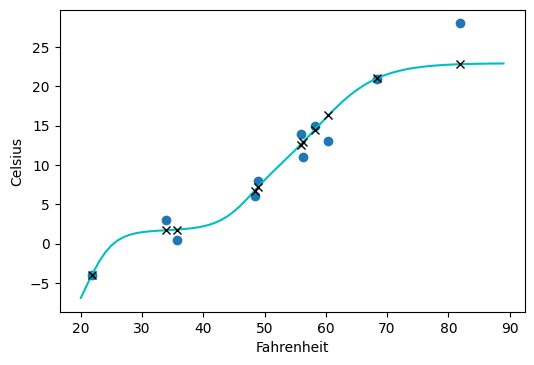

In [59]:
from matplotlib import pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=100)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u.unsqueeze(1)).detach().numpy(), 'kx')
plt.show()

In [60]:
seq_model = nn.Sequential(
                          nn.Linear(1, 11),
                          nn.Tanh(),
                          nn.Linear(11,1))
seq_model

Sequential(
  (0): Linear(in_features=1, out_features=11, bias=True)
  (1): Tanh()
  (2): Linear(in_features=11, out_features=1, bias=True)
)

In [66]:
from collections import OrderedDict
seq_model = nn.Sequential(OrderedDict([
                                      ('hidden_linear', nn.Linear(1, 11)),
                                      ('hidden_activation', nn.Tanh()),
                                      ('output_linear', nn.Linear(11, 1))
                                      ]))
seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=11, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=11, out_features=1, bias=True)
)

In [84]:
class SubclassModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden_linear = nn.Linear(1, 11)
        self.output_linear = nn.Linear(11, 1)
    def forward(self, input):
        hidden_t = self.hidden_linear(input)
        activated_t = torch.tanh(hidden_t)
        output_t = self.output_linear(activated_t)
        return output_t

In [85]:
seq_model = SubclassModel()
seq_model

SubclassModel(
  (hidden_linear): Linear(in_features=1, out_features=11, bias=True)
  (output_linear): Linear(in_features=11, out_features=1, bias=True)
)

In [86]:
optimizer = optim.Adam(seq_model.parameters(),lr = 1e-3)

In [87]:
training_loop(n_epoch = 5000, model = seq_model, loss_fn = loss_fn, optimizer = optimizer, 
              train_t_u = train_t_un, train_t_c = train_t_c, val_t_u = val_t_un, val_t_c = val_t_c)

Epoch: 500, Train_Loss: 56.56, Val_Loss: 279.17
Epoch: 1000, Train_Loss: 29.55, Val_Loss: 182.59
Epoch: 1500, Train_Loss: 14.65, Val_Loss: 123.20
Epoch: 2000, Train_Loss: 8.54, Val_Loss: 88.12
Epoch: 2500, Train_Loss: 6.04, Val_Loss: 66.98
Epoch: 3000, Train_Loss: 4.32, Val_Loss: 51.31
Epoch: 3500, Train_Loss: 3.24, Val_Loss: 39.41
Epoch: 4000, Train_Loss: 2.55, Val_Loss: 30.66
Epoch: 4500, Train_Loss: 2.09, Val_Loss: 24.14
Epoch: 5000, Train_Loss: 1.76, Val_Loss: 19.32
